In [1]:
import json
from hydra import compose, initialize
from pathlib import Path
from itertools import chain
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
import matplotlib.pyplot as plt
from ergochemics.draw import draw_molecule
from cgr.inference import ReactantGraph
from collections import defaultdict
from scipy.stats import hmean, gmean
from ergochemics.mapping import rc_to_nest

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

krs = Path(filepaths.data) / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}

with open(Path(filepaths.raw_data) / 'decarbs.json', 'w') as f:
    json.dump(decarb, f)

print(len(decarb))

86


In [3]:
embed_mat = np.load(Path(filepaths.interim_data) / 'decarb' / 'decarb_bfm.npy')
examples = pd.read_parquet(Path(filepaths.interim_data) / 'decarb' / 'subgraph_examples.parquet')

In [4]:
p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]
sgids = np.argsort(p1)[::-1]
examples['reaction_center'] = examples['reaction_center'].apply(rc_to_nest)
examples.head()

,subgraph_id,rxn_id,smarts,sg_idxs,reaction_center
0,0,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[13],"(((13, 15, 17),), ((),))"
1,1,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[12],"(((13, 15, 17),), ((),))"
2,2,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[6],"(((13, 15, 17),), ((),))"
3,3,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[10],"(((13, 15, 17),), ((),))"
4,4,14,*C(=O)OCC(COP(=O)(O)OCC(N)C(=O)O)OC(*)=O>>*C(=...,[4],"(((13, 15, 17),), ((),))"


Visualize features

Subgraph id: 65
Probability: 0.40
Example shown: 55


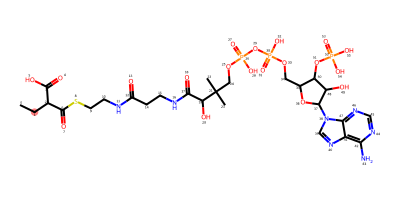

Subgraph id: 730
Probability: 0.38
Example shown: 14


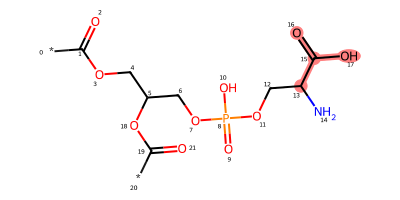

Subgraph id: 0
Probability: 0.38
Example shown: 14


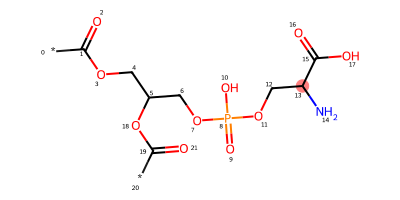

Subgraph id: 7
Probability: 0.34
Example shown: 14


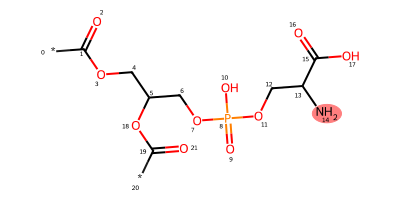

Subgraph id: 325
Probability: 0.34
Example shown: 14


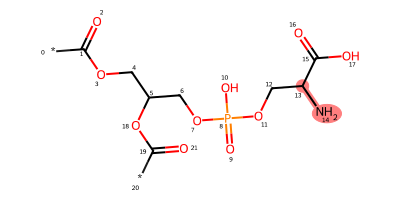

Subgraph id: 94
Probability: 0.23
Example shown: 1067


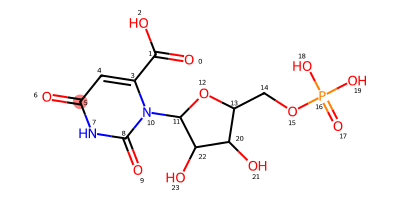

Subgraph id: 1089
Probability: 0.22
Example shown: 734


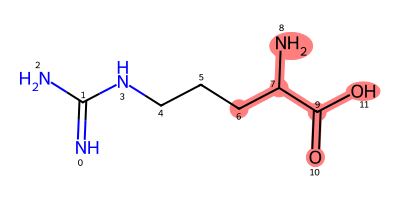

Subgraph id: 754
Probability: 0.22
Example shown: 734


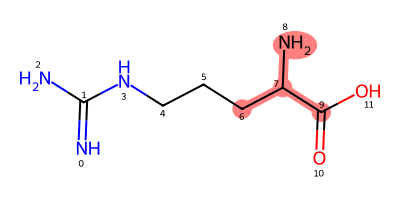

Subgraph id: 122
Probability: 0.22
Example shown: 2556


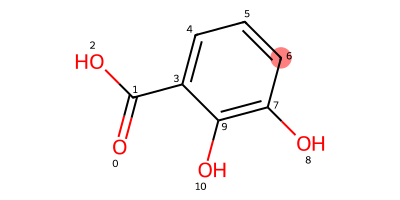

Subgraph id: 197
Probability: 0.21
Example shown: 4489


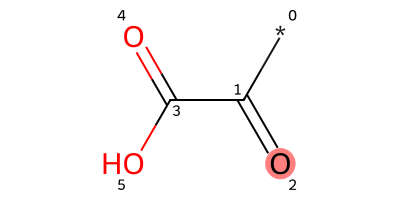

Subgraph id: 79
Probability: 0.21
Example shown: 121


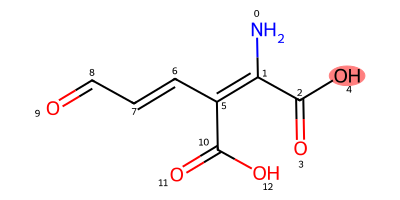

In [5]:
topk = 10
ct = 0
for sgid in sgids:
    if ct > topk:
        break

    if p1[sgid] == 1:
        continue

    ex = examples.loc[examples['subgraph_id'] == sgid].iloc[0]
    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    print(f"Example shown: {ex['rxn_id']}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    ct += 1
    

In [6]:
rxn_id = 734
len(examples.loc[examples['rxn_id'] == str(rxn_id)])
examples.loc[examples['rxn_id'] == str(rxn_id)].head()

,subgraph_id,rxn_id,smarts,sg_idxs,reaction_center
284,0,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[7],"(((7, 9, 11),), ((),))"
285,65,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[6],"(((7, 9, 11),), ((),))"
286,81,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[0],"(((7, 9, 11),), ((),))"
287,82,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[3],"(((7, 9, 11),), ((),))"
288,7,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[8],"(((7, 9, 11),), ((),))"


Subgraph id: 321
Probability: 1.00


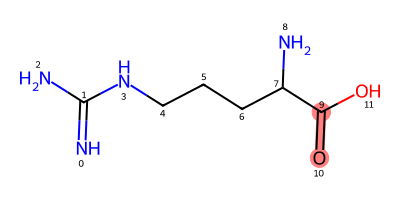

Subgraph id: 15
Probability: 1.00


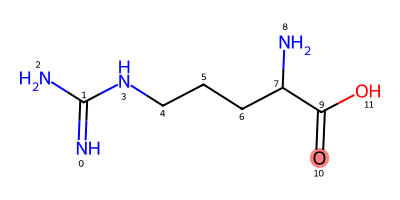

Subgraph id: 14
Probability: 1.00


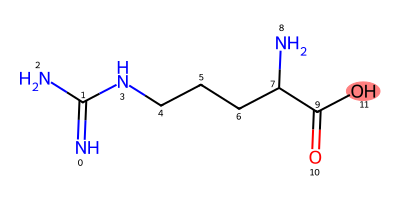

Subgraph id: 8
Probability: 1.00


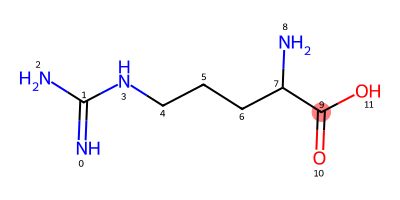

Subgraph id: 324
Probability: 1.00


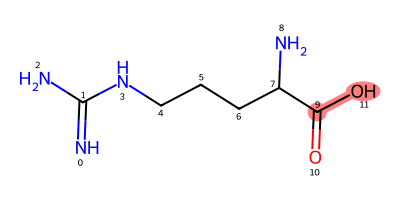

Subgraph id: 65
Probability: 0.40


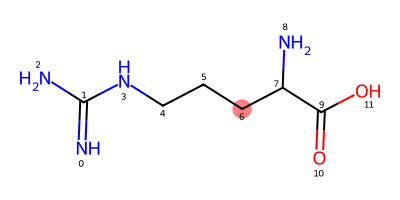

Subgraph id: 0
Probability: 0.38


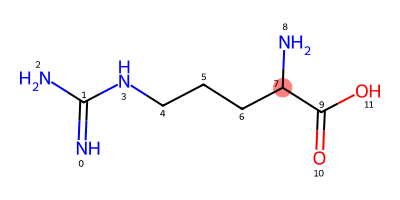

Subgraph id: 730
Probability: 0.38


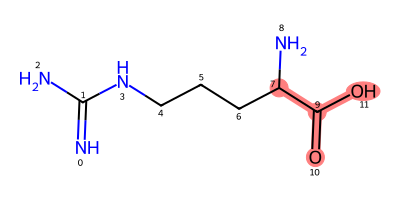

Subgraph id: 7
Probability: 0.34


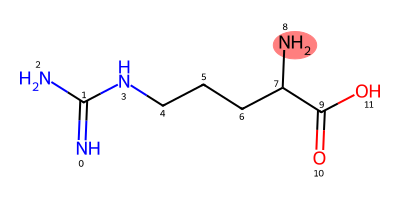

Subgraph id: 325
Probability: 0.34


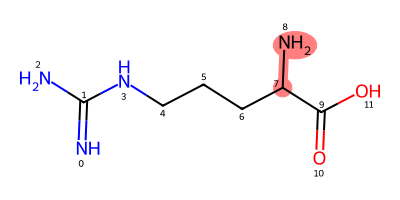

In [7]:
topk = 10
ct = 0
atom_probs = defaultdict(list)
rxn_of_interest = examples.loc[examples['rxn_id'] == str(rxn_id)].sort_values(by='subgraph_id', key=lambda x: p1[x], ascending=False)
for i, subgraph in rxn_of_interest.iterrows():
    sma = subgraph['smarts']
    sgid = subgraph["subgraph_id"]
    sg_idxs = subgraph['sg_idxs'].tolist()
    
    for idx in sg_idxs:
        atom_probs[idx].append(p1[sgid])

    if ct < topk:
        rcts = sma.split('>>')[0]
        rcts = Chem.MolFromSmiles(rcts)
        print(f"Subgraph id: {sgid}")
        print(f"Probability: {p1[sgid]:.2f}")
        display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    
    
    ct += 1

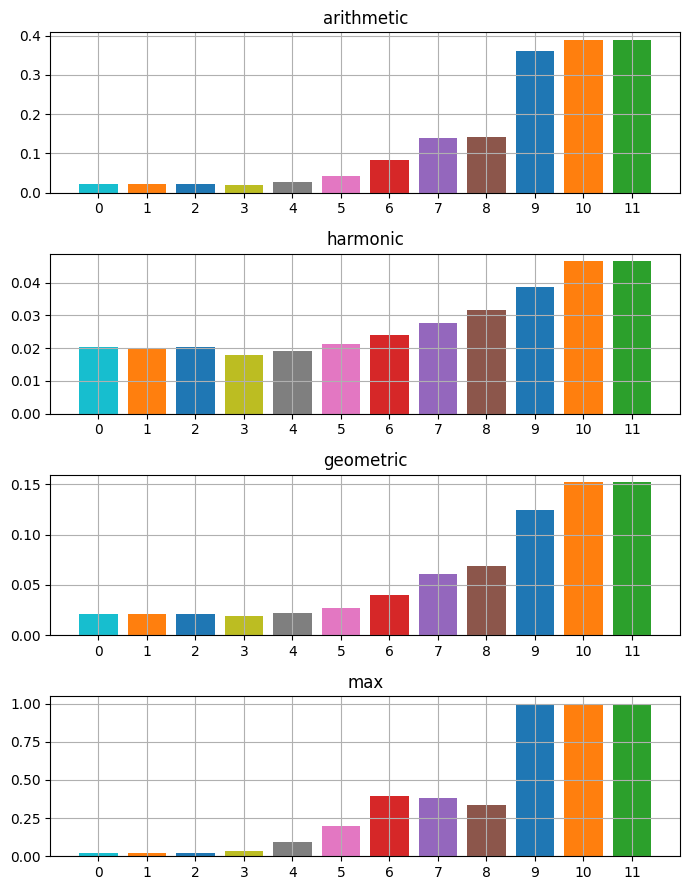

In [8]:
aggs = {
    "arithmetic": np.mean,
    "harmonic": hmean,
    "geometric": gmean,
    "max": np.max
}

fig, ax = plt.subplots(ncols=1, nrows=len(aggs), figsize=(7, 9))   
for i, (agg, func) in enumerate(aggs.items()):
    for idx, probs in atom_probs.items():
        ax[i].bar(idx, func(probs))
    ax[i].set_title(agg)
    ax[i].set_xticks(np.arange(len(atom_probs)))
    ax[i].grid()
plt.tight_layout()
plt.show()

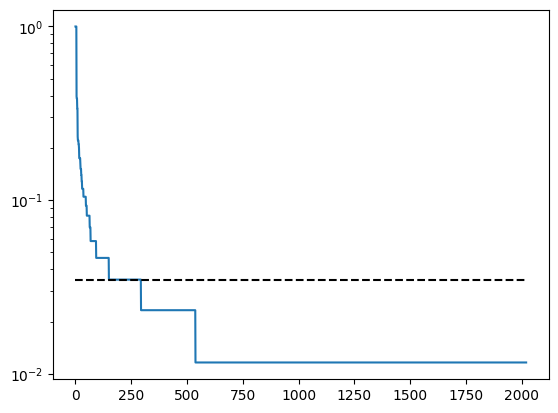

In [9]:
fig, ax = plt.subplots()
ax.plot(np.sort(p1)[::-1])
ax.hlines(3 / embed_mat.shape[0], 0, embed_mat.shape[1], colors='black', linestyles='--')
ax.set_yscale('log')
plt.show()

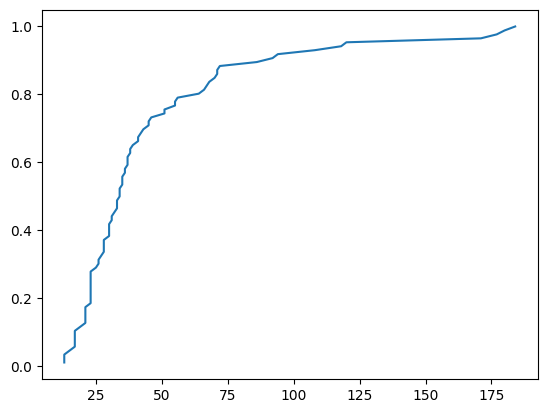

In [10]:
sg_cts = embed_mat.sum(axis=1) #/ embed_mat.shape[1]
srt_sg_cts = np.sort(sg_cts)
ycdf = np.arange(1, len(srt_sg_cts) + 1) / len(srt_sg_cts)
fig, ax = plt.subplots()
ax.plot(srt_sg_cts, ycdf)
plt.show()


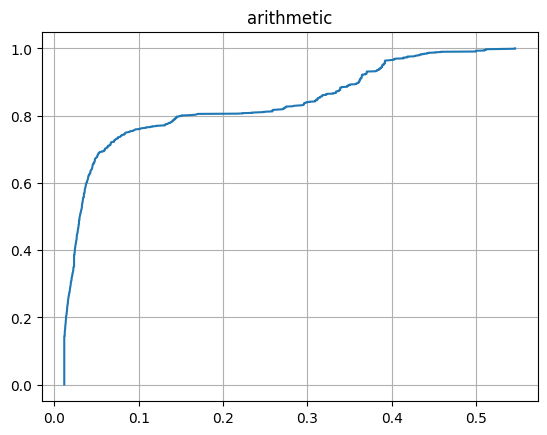

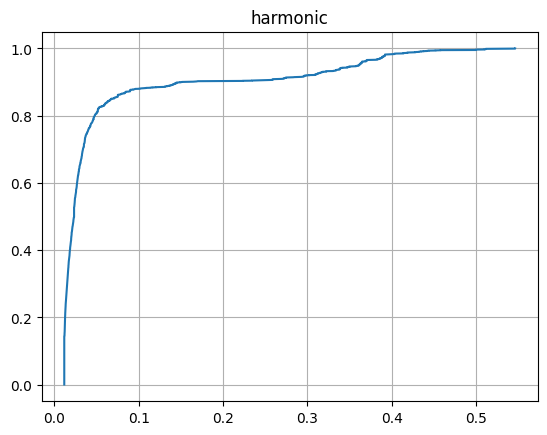

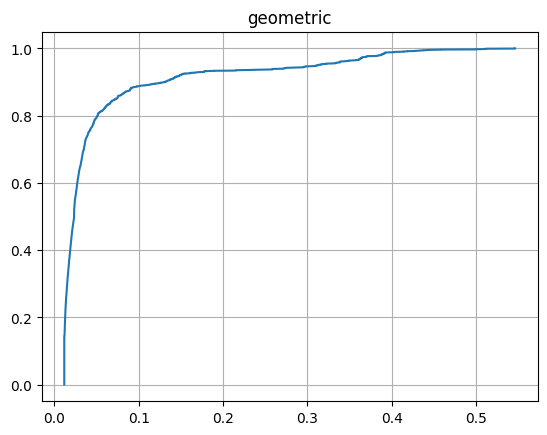

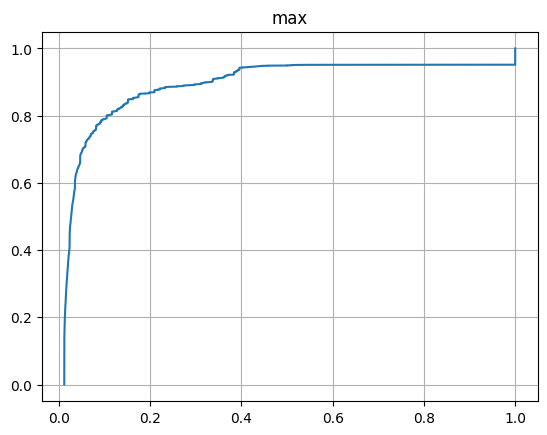

In [11]:
all_atom_probs = defaultdict(list)
for _, row in examples.iterrows():
    rxn_id = row['rxn_id']
    sgid = row['subgraph_id']
    for aidx in row['sg_idxs']:
        all_atom_probs[f"{rxn_id}_{aidx}"].append(p1[sgid])

mean_probs = []
for i, (agg, func) in enumerate(aggs.items()):
    for idx, probs in all_atom_probs.items():
        mean_probs.append(func(probs))
    fig, ax = plt.subplots()
    ycdf = np.arange(1, len(mean_probs) + 1) / len(mean_probs)
    ax.plot(np.sort(mean_probs), ycdf)
    ax.grid()
    ax.set_title(agg)
    plt.show()

Subgraph id: 730
Probability: 0.38


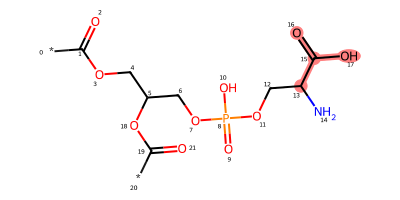

Subgraph id: 730
Probability: 0.38


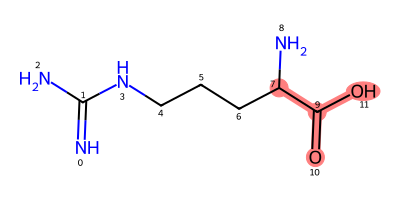

Subgraph id: 730
Probability: 0.38


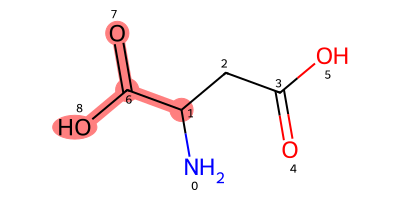

Subgraph id: 730
Probability: 0.38


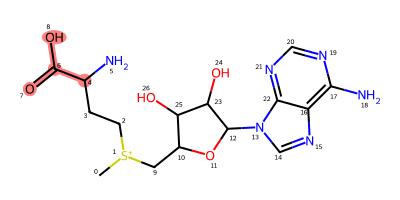

Subgraph id: 730
Probability: 0.38


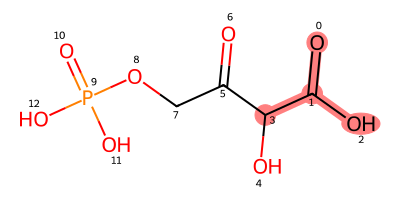

In [12]:
sgid = 730
ct = 0
for i, ex in examples.loc[examples['subgraph_id'] == sgid].iterrows():
    if ct > 4:
        break

    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    
    ct +=1

[0, 1, 2, 3, 9, 8, 6]
Example shown: 3306


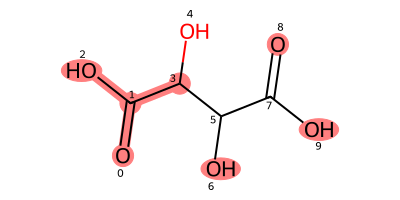

[5, 6, 7, 2, 4, 1, 3]
Example shown: 3306


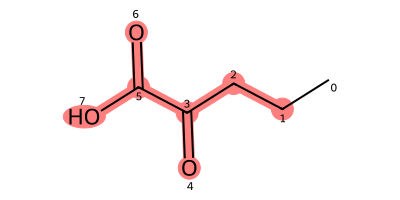

[7, 8, 9, 4, 6, 3, 5, 2]
Example shown: 3306


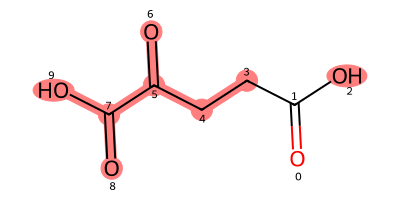

[6, 7, 8, 5, 1, 4]
Example shown: 3306


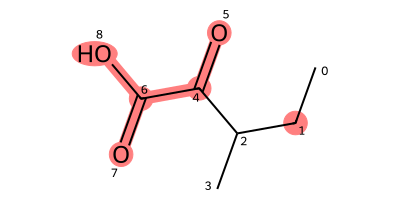

[0, 1, 2, 5, 6, 12, 8]
Example shown: 3306


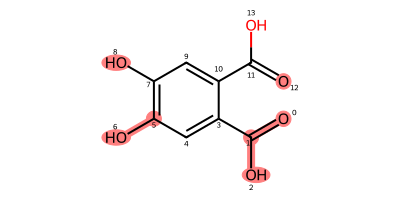

[13, 14, 15, 2, 1, 0, 3, 4, 11]
Example shown: 3306


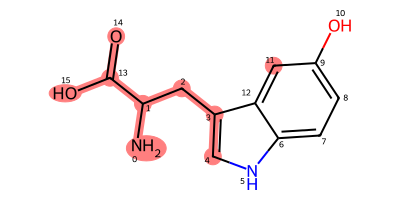

[0, 1, 2, 5, 6, 23]
Example shown: 3306


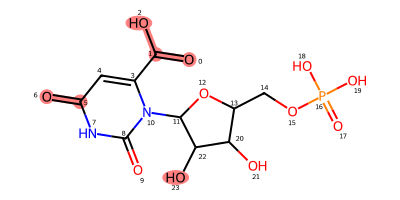

[9, 10, 11, 6, 7, 8]
Example shown: 3306


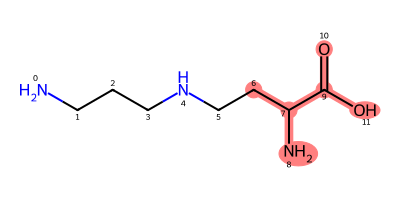

[8, 9, 10, 1, 0, 2, 7]
Example shown: 3306


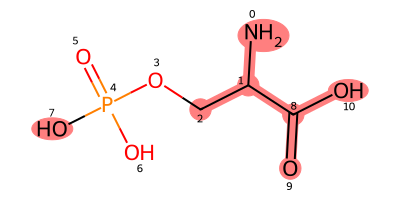

[6, 7, 8, 2, 1, 0, 5, 4]
Example shown: 3306


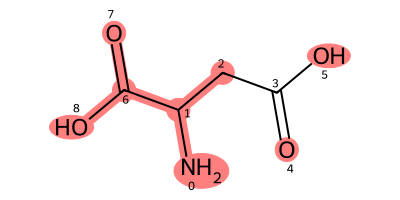

[10, 11, 12, 4, 3]
Example shown: 3306


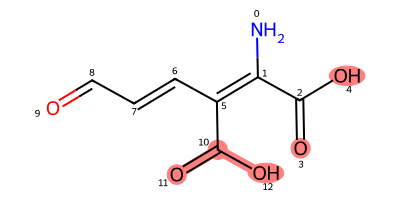

[7, 8, 9, 1, 0, 6, 5, 2]
Example shown: 3306


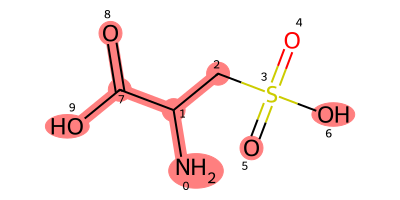

[11, 12, 13, 8, 9, 10, 7, 6]
Example shown: 3306


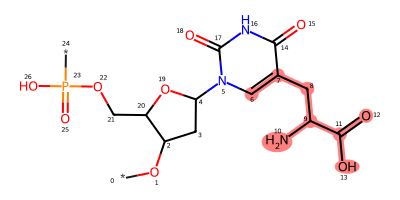

[7, 8, 9, 4, 5, 6, 3]
Example shown: 3306


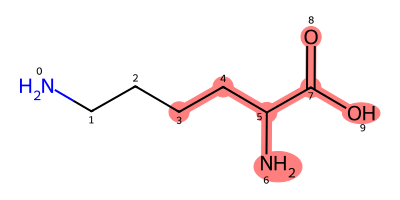

[0, 1, 2, 5, 6, 7, 4, 3, 8]
Example shown: 3306


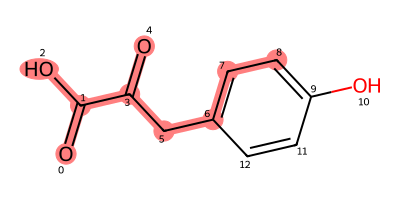

[4, 5, 6, 1, 0, 2, 3]
Example shown: 3306


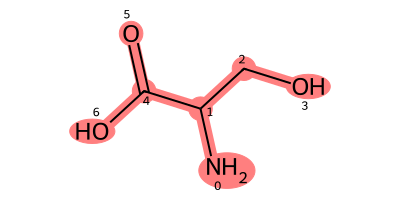

[0, 1, 2, 6, 9]
Example shown: 3306


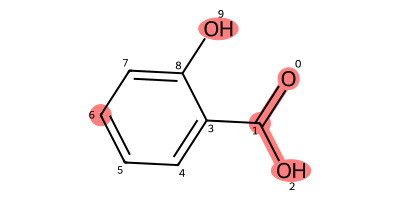

[15, 16, 17, 13, 14, 12, 10]
Example shown: 3306


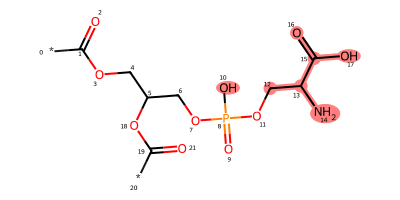

[4, 5, 6, 1, 3, 2]
Example shown: 3306


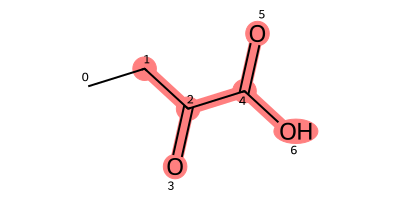

[50, 51, 52, 49]
Example shown: 3306


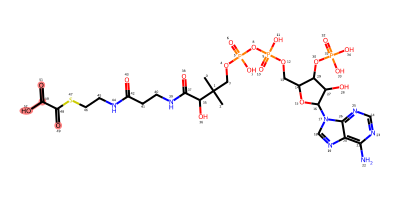

[9, 10, 11, 1, 7, 6, 13]
Example shown: 3306


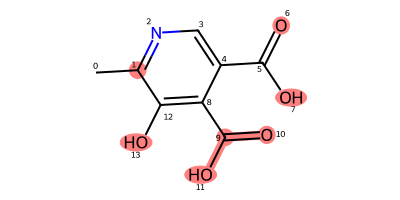

[3, 4, 5, 0]
Example shown: 3306


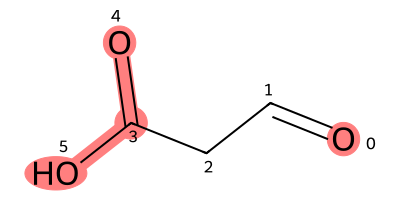

[0, 1, 2, 5, 6, 7, 4, 3, 8]
Example shown: 3306


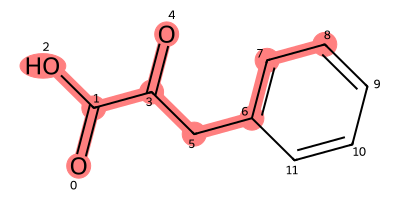

[0, 1, 2, 8, 7, 5]
Example shown: 3306


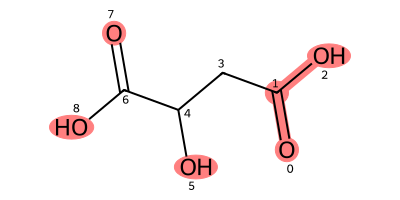

[0, 1, 2, 9, 4, 3, 8]
Example shown: 3306


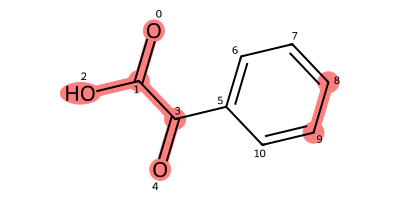

[0, 1, 2, 8, 7, 5]
Example shown: 3306


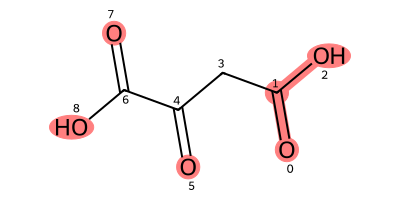

[13, 14, 15, 11, 12, 10]
Example shown: 3306


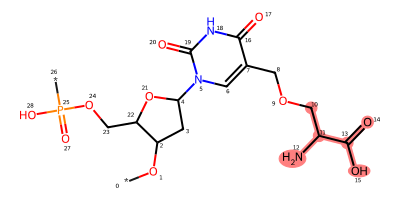

[3, 4, 5, 7, 8]
Example shown: 3306


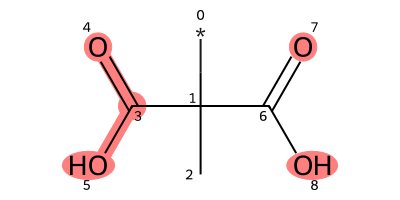

[3, 4, 5, 0]
Example shown: 3306


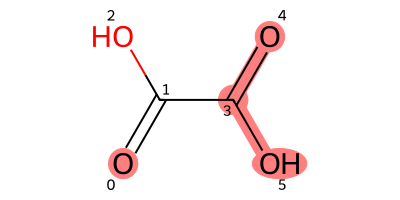

[0, 1, 2, 8, 9, 7]
Example shown: 3306


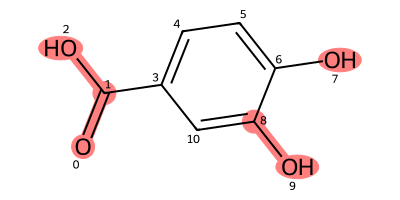

[16, 17, 18, 14, 13]
Example shown: 3306


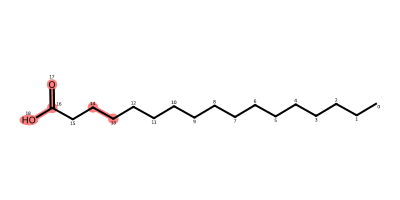

[0, 1, 2, 5, 6, 8]
Example shown: 3306


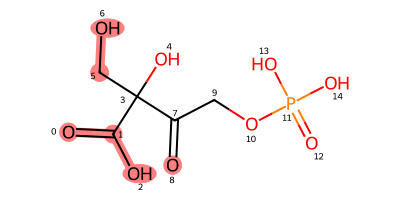

[5, 6, 7, 2, 3, 4]
Example shown: 3306


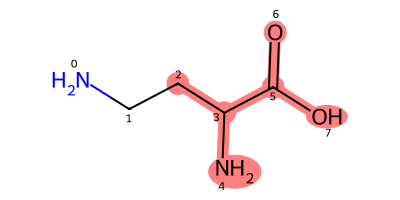

[0, 1, 2]
Example shown: 3306


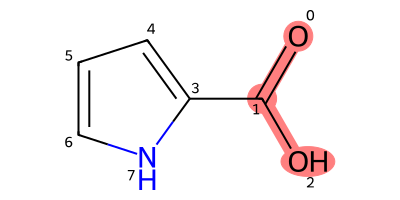

[0, 1, 2, 10, 5, 6, 8]
Example shown: 3306


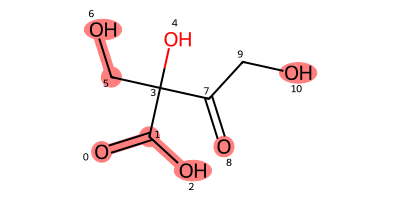

[0, 1, 2, 4, 8, 3, 7, 5]
Example shown: 3306


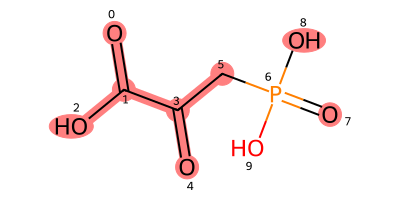

[32, 33, 34, 29, 30, 31, 28]
Example shown: 3306


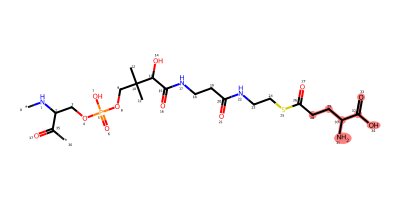

[3, 4, 5, 8, 7]
Example shown: 3306


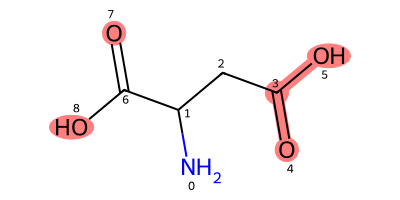

[17, 18, 19, 15, 14]
Example shown: 3306


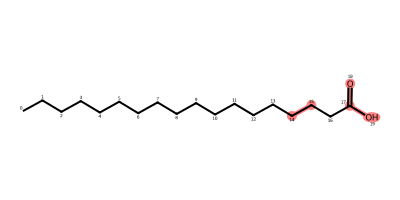

[7, 8, 9, 5, 4]
Example shown: 3306


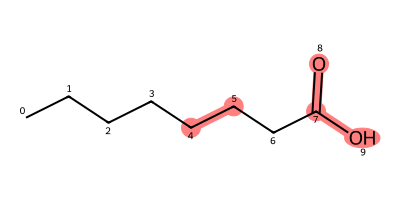

[9, 10, 11, 6, 7, 8, 5]
Example shown: 3306


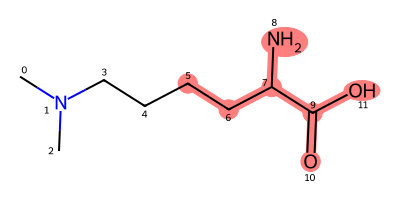

[13, 14, 15, 11, 10]
Example shown: 3306


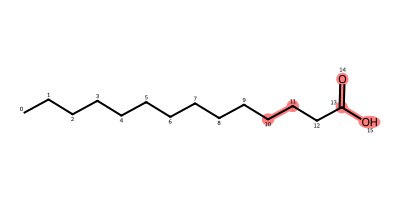

[6, 7, 8, 3, 4, 5]
Example shown: 3306


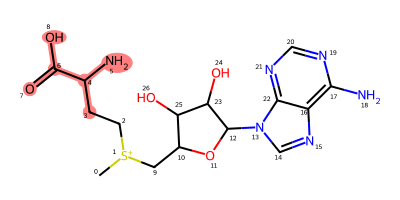

[4, 5, 6, 1, 0, 2]
Example shown: 3306


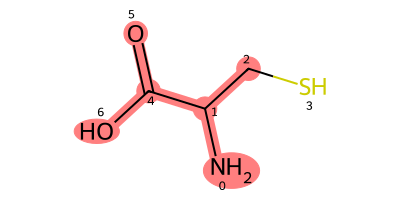

[8, 9, 10, 3, 6]
Example shown: 3306


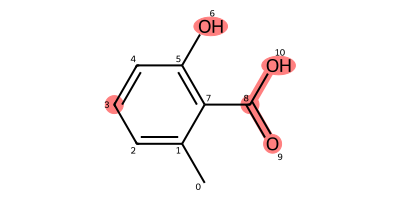

[0, 1, 2, 12, 11, 8]
Example shown: 3306


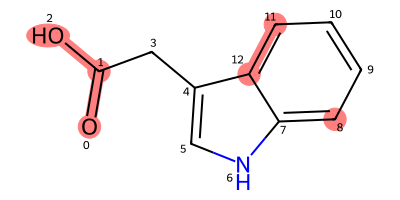

[16, 17, 18, 1, 0, 2]
Example shown: 3306


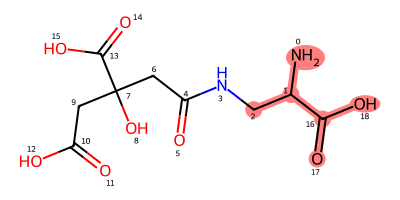

[6, 7, 8, 3, 5, 4]
Example shown: 3306


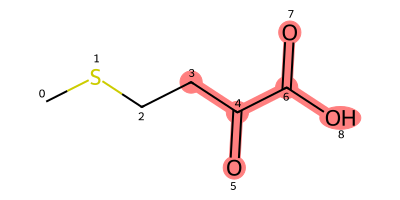

[0, 1, 2, 7, 6, 8, 10]
Example shown: 3306


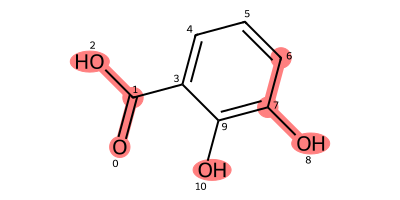

[3, 4, 5]
Example shown: 3306


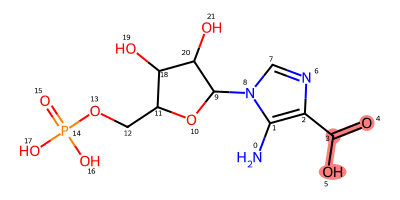

[0, 1, 2, 7, 5]
Example shown: 3306


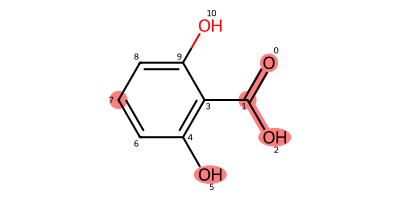

[0, 1, 2, 3, 6]
Example shown: 3306


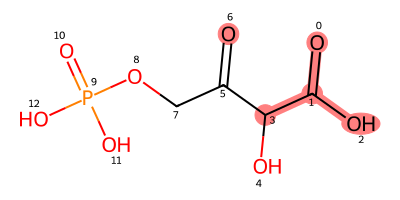

[29, 30, 31, 27]
Example shown: 3306


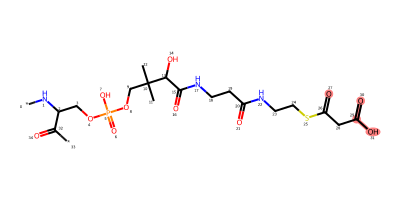

[32, 33, 34, 30, 31, 29, 27]
Example shown: 3306


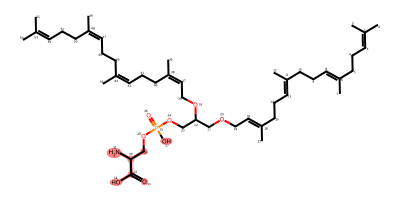

[0, 1, 2, 34, 32, 36]
Example shown: 3306


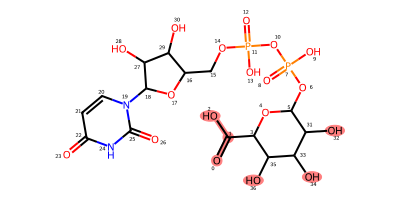

[6, 7, 8, 3, 4, 5, 2]
Example shown: 3306


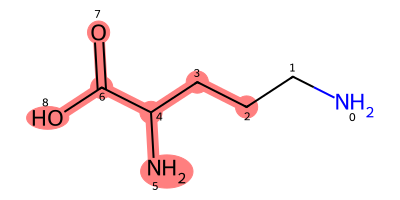

[3, 4, 5, 2]
Example shown: 3306


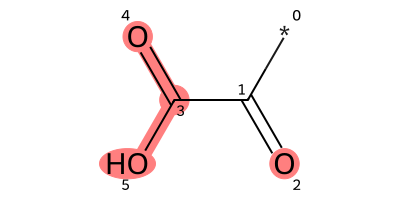

[20, 21, 22, 16, 5, 2, 15, 18]
Example shown: 3306


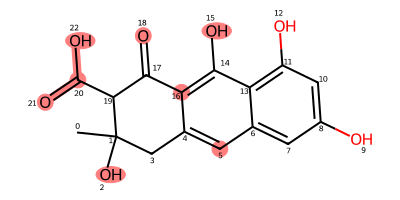

[4, 5, 6, 2]
Example shown: 3306


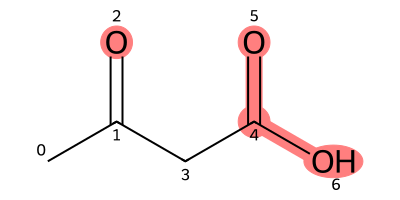

[9, 10, 11, 7, 8, 5]
Example shown: 3306


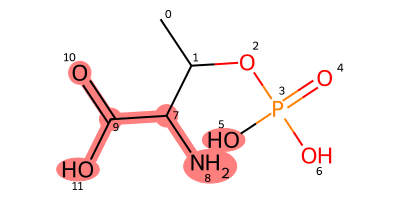

[0, 1, 2, 5, 6, 7, 4, 3, 13]
Example shown: 3306


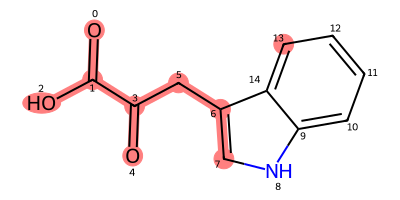

[10, 11, 12, 2, 1, 0, 3]
Example shown: 3306


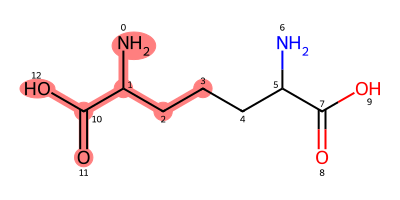

[2, 3, 4, 6]
Example shown: 3306


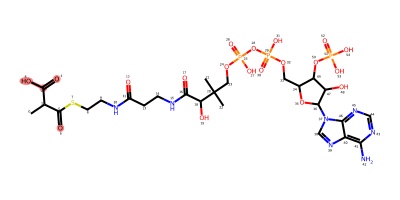

[3, 4, 5, 2, 1]
Example shown: 3306


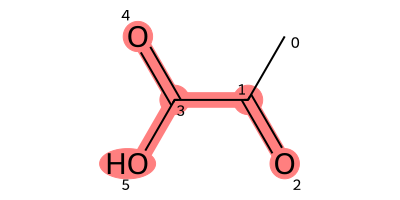

[3, 4, 5, 1, 7]
Example shown: 3306


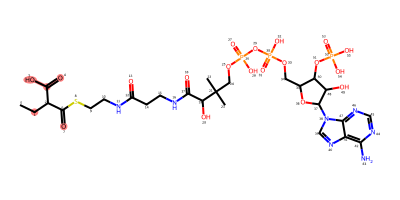

[9, 10, 11, 6, 8, 5, 7]
Example shown: 3306


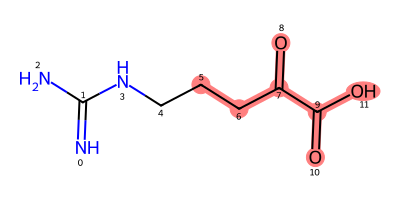

[0, 1, 2, 5, 6, 10]
Example shown: 3306


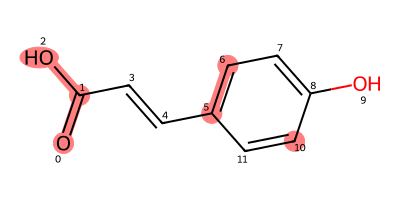

[22, 23, 24, 19, 17, 20]
Example shown: 3306


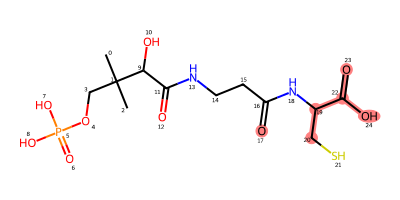

[6, 7, 8, 2]
Example shown: 3306


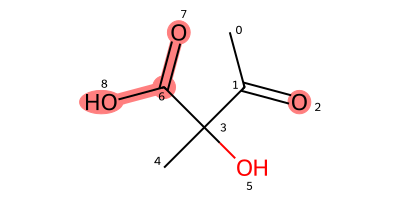

[0, 1, 2, 11, 5, 10, 8]
Example shown: 3306


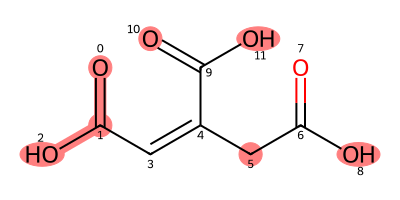

[7, 8, 9, 2, 1, 0, 3, 6]
Example shown: 3306


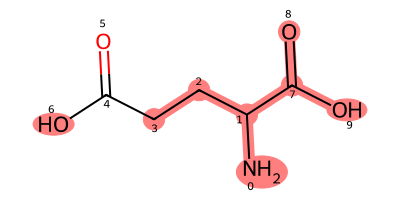

[7, 8, 9, 4, 3, 11]
Example shown: 3306


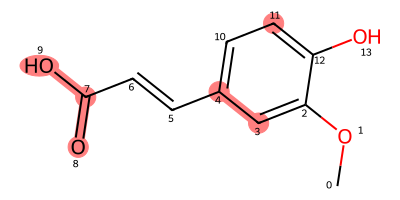

[6, 7, 8, 3, 5, 4]
Example shown: 3306


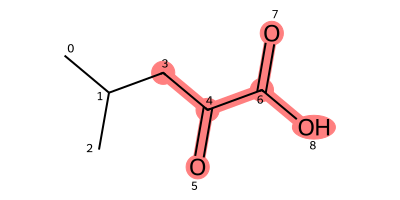

[10, 11, 12, 7, 8, 9]
Example shown: 3306


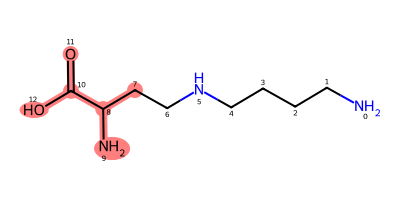

[9, 10, 11, 6, 7, 8, 5]
Example shown: 3306


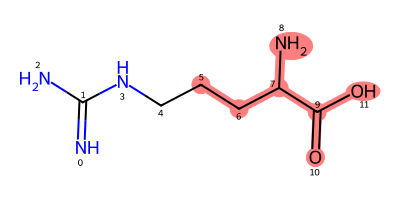

[12, 13, 14, 2, 1, 0, 3, 4, 10]
Example shown: 3306


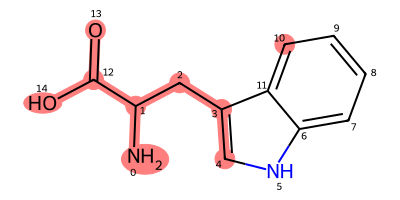

[0, 1, 2, 3, 8, 6, 10]
Example shown: 3306


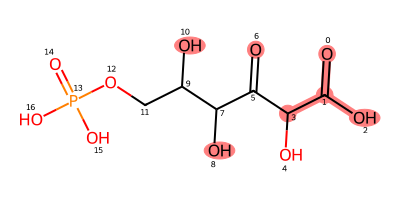

[0, 1, 2, 5, 6, 9]
Example shown: 3306


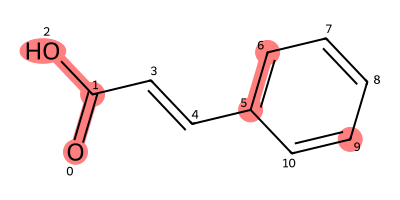

[8, 9, 10, 2, 1, 0, 3, 4, 6]
Example shown: 3306


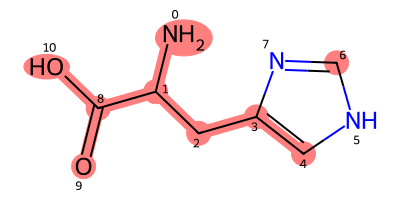

[6, 7, 8, 1, 0, 5, 4, 2]
Example shown: 3306


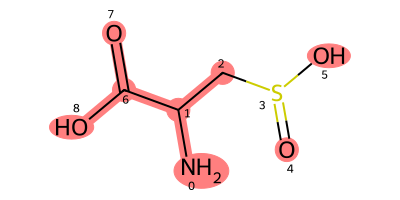

[11, 12, 13, 2, 1, 0, 3, 4, 5]
Example shown: 3306


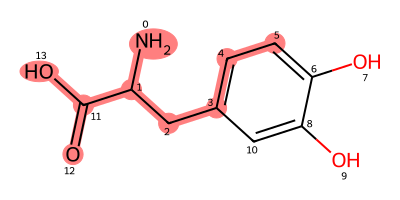

[9, 10, 11, 2, 1, 0, 3, 4, 5]
Example shown: 3306


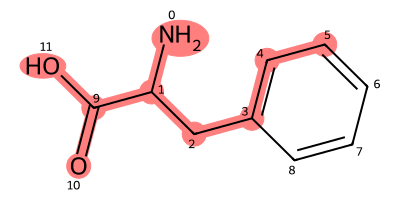

[0, 1, 2, 4, 9, 3, 8, 5]
Example shown: 3306


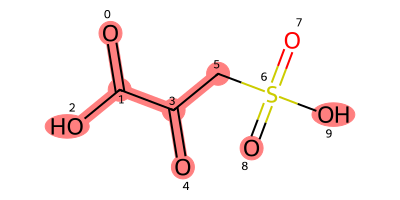

[10, 11, 12, 2, 1, 0, 3, 4, 5]
Example shown: 3306


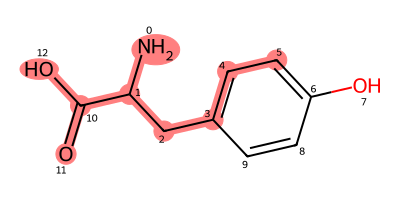

[5, 6, 7, 4, 3]
Example shown: 3306


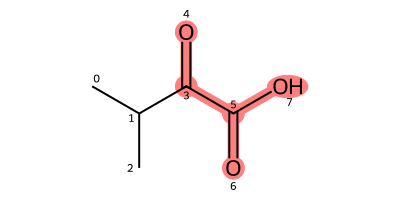

[15, 16, 17, 13, 12]
Example shown: 3306


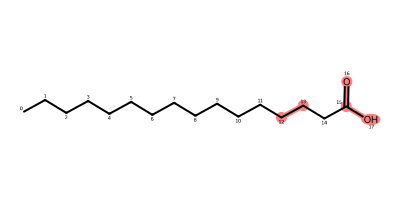

In [14]:
agg = aggs['max']
lb = 0.15

for name, gb in examples.groupby(by="rxn_id"):
    smarts = gb.iloc[0]['smarts']
    rcts = smarts.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    aidxs = [atom.GetIdx() for atom in rcts.GetAtoms()]
    sg_idxs = [elt for elt in aidxs if agg(all_atom_probs[f"{name}_{elt}"]) > lb]
    print(sorted(sg_idxs, key=lambda x: agg(all_atom_probs[f"{name}_{x}"]), reverse=True))
    print(f"Example shown: {ex['rxn_id']}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))